# [E07] Sentiment Classification

### 목차
1. Data 준비
2. Data loader
3. Data 분석 및 padding
4. Model 설계 및 훈련
5. Embedding 레이어 분석
6. Word2Vec embedding 활용
7. 회고

### 루브릭 평가 기준
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
    * 3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
    * gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
    * 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

## 1. Data 준비

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# data 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

# data의 갯수와 형태 확인
print("# of train data: {}, # of test data: {}".format(len(train_data), len(test_data)))
train_data.head()

# of train data: 150000, # of test data: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


* urllib: URL을 여는데 도움이 되는 함수와 클래스를 정의
* konlpy: 한국어 토큰화, 형태소 분석
---
* 150,000개의 train data와 50,000개의 test data

## 2. Data loader

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# stopwords: 불용어

# Data loader 함수
def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    # 중복, 특수문자 제거, 공백을 NULL로 변경, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    train_data['document'].replace('', np.nan, inplace=True)
    train_data = train_data.dropna(how = 'any')

    # test data 전처리
    # 중복, 특수문자 제거, 공백을 NULL로 변경, 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'].replace('', np.nan, inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 삭제
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) #토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 삭제
        X_test.append(temp_X)
    
    # 단어 사전
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트를 단어 사전 인덱스로 변환하는 함수
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))

# 사전 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.


train data 개수: 145791, test data 개수: 48995


* load_data(): data set 전처리 과정을 포함하며, 중복, 특수문자, 결측치를 제거하고 공백을 NULL로 변경하는 동작을 수행
* 뿐만아니라, 토큰화를 진행하는 동작도 함께 수행 후, 단어 사전을 만들고, wordlist_to_indexlist() 함수를 이용하여 텍스트를 인덱스로 변환하는 과정을 수행

In [3]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('Label: ', y_train[i])

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
Label:  0
[977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
Label:  1
[19, 192, 2]
재 <UNK>
Label:  0
[8035, 143, 4134, 277, 85, 13, 5, 52, 3326]
이야기 구먼 솔직히 재미 없 다 평점 조정
Label:  0
[2, 8488, 1051, 48, 2702, 54, 4, 2625, 34, 1118, 29, 326, 36, 17, 35, 54, 2, 2, 393, 2850, 1677, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
Label:  1
[627, 2, 2, 425, 171, 1464, 661, 1592, 665, 46, 2, 4, 61, 2167, 118, 718]
<UNK> <UNK> 세 부터 초등 학교 학년 생 인 <UNK> 영화 ㅋㅋㅋ 별반 개 아까움
Label:  0
[237, 351, 8, 354, 1909, 51, 11, 780, 5]
긴장감 을 제대로 살려 내 지 못했 다
Label:  0
[232, 1344, 132, 5, 392, 705, 2, 2, 48, 1434, 269, 93, 233, 23, 882, 24, 321, 608, 501, 475, 546, 5, 3165, 8489, 17, 1386, 1386, 65, 282, 13, 5, 48, 95, 7, 70, 17, 2, 37]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만 <UNK> 네
Label:  0
[117, 13, 18, 85, 12, 269, 22, 43, 4]
없 는데 재미 있 

* get_encoded_sentence()  : 하나의 문장을 이용하여, 단어를 인덱스로 변환하는 함수
* get_encoded_sentences() : 여러개의 문장을 이용하여, 단어를 인덱스로 변환하는 함수
* get_decoded_sentence()  : 숫자 벡터를 원래의 문장으로 변환하는 함수
* get_decoded_sentences() : 여러개의 숫자 벡터를 원래의 여러 문장으로 변환하는 함수

## 3. Data 분석 및 padding

In [4]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장 길이 평균     : ', np.mean(num_tokens))
print('문장 길이 최대     : ', np.max(num_tokens))
print('문장 길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함'.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장 길이 평균     :  13.757179674103888
문장 길이 최대     :  83
문장 길이 표준편차 :  11.462771769216866
pad_sequences maxlen :  36
전체 문장의 93.38145451931864%가 maxlen 설정값 이내에 포함


In [5]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(145791, 36)


* 문장의 길이를 padding을 이용하여 맞춤

In [6]:
x_val = X_train[:40000]
y_val = y_train[:40000]

partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(105791, 36)
(105791,)
(40000, 36)
(40000,)


* train set을 분리하여 일부를 validation set으로 사용
* 총 145791개의 train set 중, 40000개를 validation set으로 분리

## 4. Model 설계 및 훈련

### 4.1. LSTM
  
* LSTM은 RNN 중에서 가장 널리 쓰이는 모델
* RNN: Recurrent Neural Netowrk의 줄임말로, 텍스트 데이터를 다루는데 주로 사용되는 딥러닝 모델

In [7]:
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


* vocab_size: 단어 사전의 크기, 10,000개의 단어
* word_vector_dim: 단어 하나를 표현하는 embedding vector의 차원 수
* LSTM 레이어를 이용하여 model을 설계
* 최종 출력 결과는 긍정 혹은 부정을 나타내므로, 1 dimension (마지막 Dense 레이어)

In [8]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 6s 13ms/step - loss: 0.6560 - accuracy: 0.5795 - val_loss: 0.4191 - val_accuracy: 0.8278
Epoch 2/5
207/207 [==============================] - 2s 10ms/step - loss: 0.3823 - accuracy: 0.8456 - val_loss: 0.3689 - val_accuracy: 0.8382
Epoch 3/5
207/207 [==============================] - 2s 10ms/step - loss: 0.3352 - accuracy: 0.8638 - val_loss: 0.3609 - val_accuracy: 0.8417
Epoch 4/5
207/207 [==============================] - 2s 10ms/step - loss: 0.3154 - accuracy: 0.8697 - val_loss: 0.3628 - val_accuracy: 0.8402
Epoch 5/5
207/207 [==============================] - 2s 10ms/step - loss: 0.3042 - accuracy: 0.8764 - val_loss: 0.3658 - val_accuracy: 0.8388


* epochs = 5 로 설정하여 model을 학습
* model을 학습할 때, 앞에서 설정한 validation set을 함께 이용하여 학습

In [9]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 4s - loss: 0.3723 - accuracy: 0.8359
[0.3723328709602356, 0.8358607888221741]


* test set을 이용하여 model을 평가
* LSTM의 accuracy는 0.8359

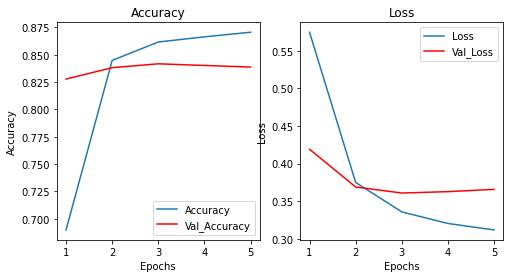

In [10]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

* accuracy와 loss를 시각화
* epochs 값이 증가할수록, training의 loss는 감소하지만, validation의 loss는 감소하다가 어느 순간 다시 증가하는 경향을 보임
* accuracy 또한 epochs 값이 증가할수록, training은 증가하지만, validation은 증가하다가 어느 순간 다시 감소하는 경향을 보임
* 이는 model이 training set에 overfitting 되었기에 나타나는 현상이라고 판단

### 4.2. 1-D CNN
  
* 1-D CNN은 1-D Convolutional Neural Network의 줄임말
* 문장 전체를 한꺼번에 한 방향으로 필터로 스캐닝하면서 필터 크기만큼의 단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식

In [11]:
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

* vocab_size: 단어 사전의 크기, 10,000개의 단어
* word_vector_dim: 단어 하나를 표현하는 embedding vector의 차원 수
* 1-D CNN 레이어를 이용하여 model을 설계
* model 설계 과정에서 풀링 계층을 이용 (MaxPooling1D)
* 최종 출력 결과는 긍정 혹은 부정을 나타내므로, 1 dimension (마지막 Dense 레이어)

In [12]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 7s 21ms/step - loss: 0.6277 - accuracy: 0.6591 - val_loss: 0.3750 - val_accuracy: 0.8338
Epoch 2/5
207/207 [==============================] - 2s 8ms/step - loss: 0.3511 - accuracy: 0.8499 - val_loss: 0.3588 - val_accuracy: 0.8431
Epoch 3/5
207/207 [==============================] - 2s 7ms/step - loss: 0.3093 - accuracy: 0.8708 - val_loss: 0.3595 - val_accuracy: 0.8440
Epoch 4/5
207/207 [==============================] - 2s 7ms/step - loss: 0.2790 - accuracy: 0.8867 - val_loss: 0.3640 - val_accuracy: 0.8446
Epoch 5/5
207/207 [==============================] - 2s 7ms/step - loss: 0.2595 - accuracy: 0.8969 - val_loss: 0.3751 - val_accuracy: 0.8424


* epochs = 5 로 설정하여 model을 학습
* model을 학습할 때, 앞에서 설정한 validation set을 함께 이용하여 학습

In [13]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 4s - loss: 0.3835 - accuracy: 0.8380
[0.3834507167339325, 0.8380242586135864]


* test set을 이용하여 model을 평가
* 1-D CNN의 accuracy는 0.8380

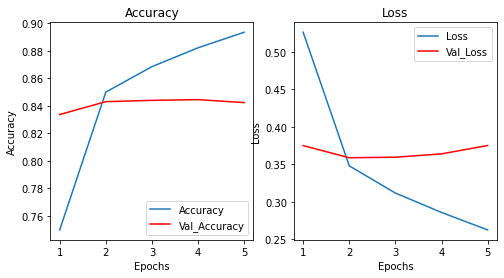

In [14]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

* accuracy와 loss를 시각화
* epochs 값이 증가할수록, training의 loss는 감소하지만, validation의 loss는 감소하다가 어느 순간 다시 증가하는 경향을 보임
* accuracy 또한 epochs 값이 증가할수록, training은 증가하지만, validation은 증가하다가 어느 순간 거의 일정해지는 경향을 보임
* 이는 model이 training set에 overfitting 되었기에 나타나는 현상이라고 판단

### 4.3. GlobalMaxPooling1D
  
* GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
* 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식

In [15]:
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


* vocab_size: 단어 사전의 크기, 10,000개의 단어
* word_vector_dim: 단어 하나를 표현하는 embedding vector의 차원 수
* GlobalMaxPooling1D 레이어 하나만 이용하여 model을 설계
* 최종 출력 결과는 긍정 혹은 부정을 나타내므로, 1 dimension (마지막 Dense 레이어)

In [16]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 2s 5ms/step - loss: 0.6662 - accuracy: 0.6646 - val_loss: 0.4599 - val_accuracy: 0.8108
Epoch 2/5
207/207 [==============================] - 1s 5ms/step - loss: 0.4178 - accuracy: 0.8284 - val_loss: 0.3773 - val_accuracy: 0.8312
Epoch 3/5
207/207 [==============================] - 1s 5ms/step - loss: 0.3449 - accuracy: 0.8552 - val_loss: 0.3639 - val_accuracy: 0.8377
Epoch 4/5
207/207 [==============================] - 1s 5ms/step - loss: 0.3105 - accuracy: 0.8707 - val_loss: 0.3623 - val_accuracy: 0.8401
Epoch 5/5
207/207 [==============================] - 1s 5ms/step - loss: 0.2873 - accuracy: 0.8826 - val_loss: 0.3655 - val_accuracy: 0.8416


* epochs = 5 로 설정하여 model을 학습
* model을 학습할 때, 앞에서 설정한 validation set을 함께 이용하여 학습

In [17]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3723 - accuracy: 0.8371
[0.3723200261592865, 0.8371262550354004]


* test set을 이용하여 model을 평가
* GlobalMaxPooling1D의 accuracy는 0.8371

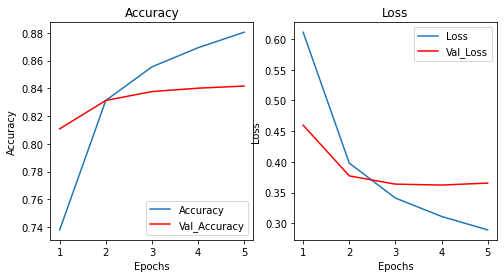

In [18]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

* accuracy와 loss를 시각화
* epochs 값이 증가할수록, training의 loss는 감소하지만, validation의 loss는 감소하다가 어느 순간 다시 증가하는 경향을 보임
* accuracy 또한 epochs 값이 증가할수록, training은 증가하지만, validation은 증가하다가 어느 순간 다시 감소하는 경향을 보임
* 하지만, 이 전 두 model과는 다르게 증가(감소)폭이 적은 것으로 확인
* 이는 model이 training set에 overfitting 되었기에 나타나는 현상이라고 판단

### 4.4. Bidirectional LSTM
  
* 양방향 LSTM이라고 불리며, 기존의 LSTM 계층에 역방향으로 처리하는 LSTM 계층을 추가
* 최종 은닉 상태는 두 LSTM 계층의 은닉 상태를 연결한 vector를 출력
* 최근 머신러닝 분야에서 좋은 성과에 적용된 모델일 정도로 높은 성능의 알고리즘 중 하나

In [19]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences = False), input_shape = (49,1)))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                5920      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 328       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 166,257
Trainable params: 166,257
Non-trainable params: 0
_________________________________________________________________


* vocab_size: 단어 사전의 크기, 10,000개의 단어
* word_vector_dim: 단어 하나를 표현하는 embedding vector의 차원 수
* Bidirectional LSTM 레이어 하나만 이용하여 model을 설계
* 최종 출력 결과는 긍정 혹은 부정을 나타내므로, 1 dimension (마지막 Dense 레이어)

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1653/1653 [==============================] - 31s 17ms/step - loss: 0.4831 - accuracy: 0.7448 - val_loss: 0.3561 - val_accuracy: 0.8424
Epoch 2/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.3237 - accuracy: 0.8608 - val_loss: 0.3426 - val_accuracy: 0.8451
Epoch 3/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.2902 - accuracy: 0.8725 - val_loss: 0.3445 - val_accuracy: 0.8462
Epoch 4/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.2651 - accuracy: 0.8847 - val_loss: 0.3633 - val_accuracy: 0.8481
Epoch 5/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.2395 - accuracy: 0.8982 - val_loss: 0.3672 - val_accuracy: 0.8461


* epochs = 5 로 설정하여 model을 학습
* model을 학습할 때, 앞에서 설정한 validation set을 함께 이용하여 학습

In [21]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 9s - loss: 0.3722 - accuracy: 0.8449
[0.37218552827835083, 0.844902515411377]


* test set을 이용하여 model을 평가
* Bidirectional LSTM의 accuracy는 0.8449

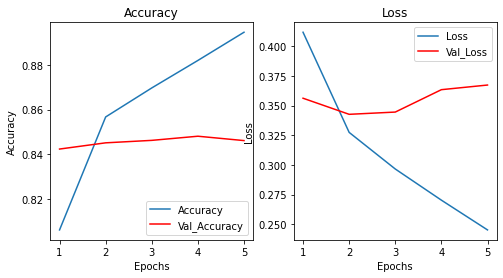

In [22]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

* accuracy와 loss를 시각화
* epochs 값이 증가할수록, training의 loss는 감소하지만, validation의 loss는 감소하다가 어느 순간 다시 증가하는 경향을 보임
* accuracy 또한 epochs 값이 증가할수록, training은 증가하지만, validation은 증가하다가 어느 순간 일정해지는 경향을 보임
* validation loss가 증가하는 폭이 다른 model에 비해서 큰 편임을 확인
* accuracy는 다른 model들에 비해 좋은 편이었지만, validation loss 값이 크게 증가하는 것으로 보아, overfitting 되었을 확률이 높다고 판단 

### 4.5. Bidirectional LSTM + Dropout

In [23]:
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences = False), input_shape = (49,1)))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                5920      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 328       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 166,257
Trainable params: 166,257
Non-trainable params: 0
_________________________________________________________________


* vocab_size: 단어 사전의 크기, 10,000개의 단어
* word_vector_dim: 단어 하나를 표현하는 embedding vector의 차원 수
* Bidirectional LSTM + Dropout 레이어를 이용하여 model을 설계
* 최종 출력 결과는 긍정 혹은 부정을 나타내므로, 1 dimension (마지막 Dense 레이어)

In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1653/1653 [==============================] - 30s 17ms/step - loss: 0.4797 - accuracy: 0.7591 - val_loss: 0.3639 - val_accuracy: 0.8373
Epoch 2/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.3309 - accuracy: 0.8589 - val_loss: 0.3624 - val_accuracy: 0.8400
Epoch 3/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.2948 - accuracy: 0.8711 - val_loss: 0.3470 - val_accuracy: 0.8465
Epoch 4/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.2651 - accuracy: 0.8867 - val_loss: 0.3630 - val_accuracy: 0.8470
Epoch 5/5
1653/1653 [==============================] - 27s 16ms/step - loss: 0.2404 - accuracy: 0.8973 - val_loss: 0.3890 - val_accuracy: 0.8462


* epochs = 5 로 설정하여 model을 학습
* model을 학습할 때, 앞에서 설정한 validation set을 함께 이용하여 학습

In [25]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 9s - loss: 0.3939 - accuracy: 0.8428
[0.39388102293014526, 0.8428410887718201]


* test set을 이용하여 model을 평가
* Bidirectional LSTM + Dropout의 accuracy는 0.8428

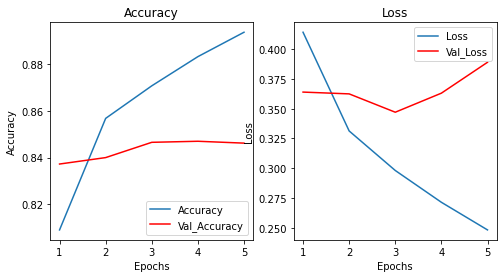

In [26]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

* accuracy와 loss를 시각화
* epochs 값이 증가할수록, training의 loss는 감소하지만, validation의 loss는 감소하다가 어느 순간 다시 증가하는 경향을 보임
* accuracy 또한 epochs 값이 증가할수록, training은 증가하지만, validation은 증가하다가 어느 순간 일정해지는 경향을 보임
* validation loss가 증가하는 폭이 다른 model에 비해서 굉장히 큰 편임을 확인
* accuracy는 다른 model들에 비해 좋은 편이었지만, validation loss 값이 크게 증가하는 것으로 보아, overfitting 되었을 확률이 높다고 판단

## 5.Embedding 레이어 분석

In [27]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


* gensim: 머신 러닝을 사용하는 비지도 주제 모델링 및 자연어 처리를 위한 오픈 소스 라이브러리

In [28]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

* 학습한 embedding parameter를 파일에 적어서 저장
* for문을 이용하여, 특수 문자를 제외한 단어 갯수 만큼의 워드 벡터를 파일에 기록

In [29]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('균', 0.9849216341972351),
 ('실감', 0.9829123020172119),
 ('구할', 0.9825371503829956),
 ('느낍니다', 0.9812541007995605),
 ('담백', 0.9810580015182495),
 ('저격', 0.9803206920623779),
 ('견', 0.9802027940750122),
 ('두려워', 0.9789497256278992),
 ('엄연히', 0.97869473695755),
 ('대인', 0.978488028049469)]

* 파일에 기록된 embedding parameter를 이용하여, word vector로 활용
* 주어진 단어를 기준으로 유사한 단어, 유사도를 출력
* '사랑'이라는 단어를 기준으로 유사도를 확인해본 결과, 연관성이 없다고 봐도 무방할 정도의 단어들이 출력
* 해당 단어들의 유사도는 0.85 이상으로, 꽤 높은 유사도를 보여주고 있음
* 실제 유사한 단어가 아님에도 높은 유사도를 보이는 것은, 주어진 단어가 한글이기 때문에 gensim이 잘 작동하지 않는다고 판단됨

## 6. Word2Vec embedding 활용

In [30]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(200,)

In [31]:
word2vec.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

* 5번에서 확인한 유사 단어들과는 다르게, 한국어 word2vec embedding을 활용한 결과, 유사하다고 판단할 수 있는 단어들이 출력
* 유사도는 0.59~0.72 사이로 높은 편은 아니지만, 단어의 의미를 살펴보면 어느정도 유사한 단어를 잘 출력하고 있다고 판단

In [32]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [33]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


* LSTM 레이어를 이용한 model을 설계

In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1653/1653 [==============================] - 33s 19ms/step - loss: 0.5557 - accuracy: 0.6741 - val_loss: 0.3467 - val_accuracy: 0.8462
Epoch 2/5
1653/1653 [==============================] - 31s 19ms/step - loss: 0.3107 - accuracy: 0.8665 - val_loss: 0.3276 - val_accuracy: 0.8571
Epoch 3/5
1653/1653 [==============================] - 29s 17ms/step - loss: 0.2563 - accuracy: 0.8930 - val_loss: 0.3287 - val_accuracy: 0.8581
Epoch 4/5
1653/1653 [==============================] - 28s 17ms/step - loss: 0.2166 - accuracy: 0.9121 - val_loss: 0.3487 - val_accuracy: 0.8561
Epoch 5/5
1653/1653 [==============================] - 30s 18ms/step - loss: 0.1785 - accuracy: 0.9286 - val_loss: 0.3794 - val_accuracy: 0.8553


In [35]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 6s - loss: 0.3851 - accuracy: 0.8512
[0.385079562664032, 0.8511685132980347]


* 0.8510의 accuracy가 측정되었음

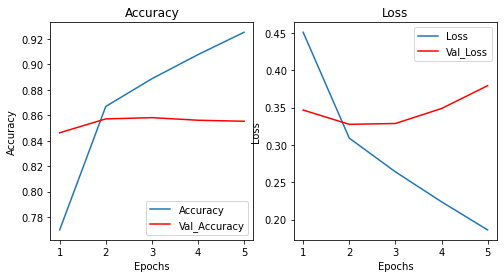

In [36]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

* training set과 validation set을 비교해본 결과, 앞서 확인했던 LSTM model과 굉장히 유사한 경향을 갖는 것으로 판단
* word2vec를 이용한 경우, 실제로 model이 크게 향상되지는 않았음
* 그러나, 한국어를 분석하기에는 word2vec가 더 적합하므로, 측정된 accuracy의 신뢰성을 높일 수 있다고 판단
* 실제 유사 단어를 살펴보았을 때, word2vec을 사용한 경우에는 유사한 단어들이 출력되었음

## 7. 회고

* 노드에 나와있는 LSTM, 1-D CNN, GlobalMaxPooling1D 단일 레이어뿐만 아니라, 추가적으로 Bidirectional LSTM, Bidirectional LSTM + Dropout 레이어를 이용한 model까지, 총 5개의 model을 이용하여 학습을 시켰다. 정확도는 0.83~0.84까지로 큰 차이는 없었다. 그러나, validation loss를 확인했을 때, Bidirectional LSTM을 이용한 케이스들에 대해서는 validation loss가 감소하다가 급격하게 증가하는 경향을 보였다. 왜 이런 경향을 보이는 건지는 잘 모르겠지만, 내가 생각해본 이유는 **(1)Bidirectional LSTM의 hyperparameter 설정이 잘못되었거나,** **(2)Bidirectional LSTM이 자연어 처리에서는 영향력이 크지 않거나** 둘중 하나라고 생각된다. 아마도 전자가 더 신빙성있고 가능성이 높은 이유라고 생각한다.
  
  
* gensim을 이용하여 유사어를 출력했을 때, input으로 주어진 단어와는 전혀 상관없는 단어들이 유사어로 출력되었고, 그 단어들의 유사도는 높은 편으로 출력되었다. 아마도 gensim은 한국어보다는 영어에 적합한 라이브러리가 아닐까라는 생각이 든다. 반면에 Word2Vec을 이용하여 유사어를 출력했을 때, input으로 주어진 단어와 상대적으로 굉장히 유사한 단어들이 출력되었다. 유사도는 gensim에 비해서 많이 떨어졌지만, 실제 단어의 의미를 살펴봤을 때, gensim보다 유사하다고 판단할 수 있는 단어들이 출력된 것을 확인했고, Word2Vec은 gensim보다 한국어에 더 적합한 라이브러리임을 확인할 수 있었다.
  
  
* 정확도를 85% 이상 넘기는 것이 어려웠다. 여러 model을 사용했지만, 대부분 83%~84%의 정확도를 보였고, hyperparameter를 바꿔도 정확도의 큰 차이는 없었다. 한국어가 복잡하기 때문에 이런 경향을 보인다고 생각된다. 또한, input으로 주어진 네이버 영화 리뷰 데이터 자체의 문제가 있을 수도 있다고 판단된다. 아무래도 어린 사람들이 사용하는 줄임말, 은어, 비속어 등 다양한 단어들을 판단하기에는 힘들지 않을까 생각된다. 이 부분을 해결할 수 있는가에 대해서는 잘 모르겠다. 어쩌면, NLP 분야에서 난이도가 가장 어려운 언어는 한국어가 아닐까 생각된다.

  
---
  
* 개인적으로 NLP 노드는 뭔가 애매하다는 느낌이 강하다. '출력 결과를 신뢰할 수 있는가'라는 의문이 항상 드는 분야이다. 이번 노드를 진행하면서 이러한 의문이 더 커졌다. 모델의 성능은 0.83~0.84로 높은 편이지만, input과는 전혀 상관없는 유사 단어를 출력했고, 한국어에 적합한 라이브러리를 사용한 경우, 유사도가 많이 떨어지는 경향이 보였다. 설계한 모델, 출력 결과들을 어떻게 이용해야 신뢰도를 높일 수 있을지에 대해서 고민해봐야겠다.

